In [127]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
from evaluation import *
from calc_wasserstein import *
%matplotlib inline

In [197]:
train_data = np.load('../data/dataset-C4-depth1/training-validation.npz')

X_train, y_train = train_data['X_train'], train_data['y_train']

# Split the data to training - validation (not testing yet!)
X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)

(45030, 33) (45030, 3)


In [198]:
test_data = np.load('../data/dataset-C4-depth1/testing.npz')

X_test, y_test = test_data['X_test'], test_data['y_test']

print(X_test.shape, y_test.shape)

(14073, 33) (14073, 3)


In [199]:
X_test_coords = extract_relative_coordinates(X_test)
X_test_coords = np.asarray(X_test_coords)

# Test the models

In [23]:
all_results = {}
datasets = ["dataset-C4-depth1", "dataset-C4-depth2", "dataset-O2-depth1", "dataset-O2-depth2"]
for d in datasets:
    all_results[d] = []

## Dataset-C4-Depth1

### 1. SCR

In [200]:
from sklearn.svm import SVR

# Initialize the base model
base_svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Wrap the base model with MultiOutputRegressor
multi_svr_model = MultiOutputRegressor(base_svr_model)

# Train the model
multi_svr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = multi_svr_model.predict(X_test)

In [102]:
metrics = eval_regression(y_test, y_pred, X_test_coords)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.00855193571048662
R2 Bestimmtheitsmaß:  0.9788541694464419
Average Cosine Similarity:  0.9925045832445109
Average Angle (degrees):  3.496825765650536
Durschnittliche Bindungslänge Differenz:  0.0239336445254672
Die Wasserstein Distanz zwischen den beiden Winkelverteilungen beträgt:  0.3470397688244627


In [24]:
all_results["dataset-C4-depth1"].append(("SVR", metrics))

#### Winkelverteilungen

In [205]:
all_angles_test = all_angles_H_central_neighbor(X_test_coords, y_test)

In [206]:
all_angles_pred = all_angles_H_central_neighbor(X_test_coords, y_pred)

In [207]:
# Calculate Wasserstein distance
distance = calculate_wasserstein_distance(all_angles_test, all_angles_pred, bins=180, range=(0, 180))
print(f'Wasserstein distance: {distance}')

Wasserstein distance: 0.3425471943911502


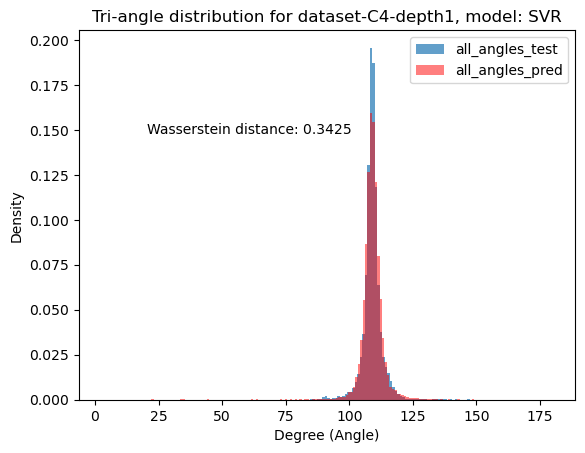

In [208]:
# Plot histograms
plt.hist(all_angles_test, bins=180, density=True, alpha=0.7, label='all_angles_test')
plt.hist(all_angles_pred, bins=180, density=True, alpha=0.5, color="red", label='all_angles_pred')
plt.title("Tri-angle distribution for dataset-C4-depth1, model: SVR")
plt.xlabel("Degree (Angle)")
plt.ylabel("Density")

# Add Wasserstein distance text
plt.text(0.55, 0.75, f'Wasserstein distance: {distance:.4f}', 
         horizontalalignment='right', 
         verticalalignment='top', 
         transform=plt.gca().transAxes)

# Add legend
plt.legend()

# Save plot
plt.savefig("../img/testing/dataset-C4-depth1/tri-angle-distribution.png", bbox_inches='tight')
plt.show()

#### Bindungslängenverteilungen

In [201]:
all_bindinglengths_test = bindungslängen(y_test)

In [202]:
all_bindinglengths_pred = bindungslängen(y_pred)

In [203]:
# Calculate Wasserstein distance
distance = calculate_wasserstein_distance(all_bindinglengths_test, all_bindinglengths_pred, bins=100, range=(0, 1.5))
print(f'Wasserstein distance: {distance}')

Wasserstein distance: 0.06255382647623076


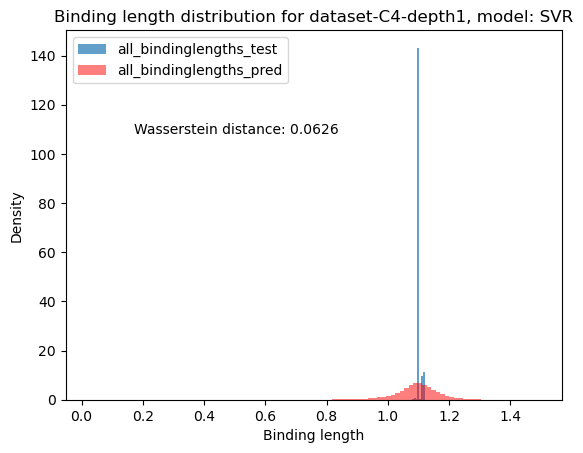

In [204]:
# Plot histograms
plt.hist(all_bindinglengths_test, bins=100, density=True, alpha=0.7, label='all_bindinglengths_test')
plt.hist(all_bindinglengths_pred, bins=100, density=True, alpha=0.5, color="red", label='all_bindinglengths_pred')
plt.title("Binding length distribution for dataset-C4-depth1, model: SVR")
plt.xlabel("Binding length")
plt.ylabel("Density")

# Add Wasserstein distance text
plt.text(0.55, 0.75, f'Wasserstein distance: {distance:.4f}', 
         horizontalalignment='right', 
         verticalalignment='top', 
         transform=plt.gca().transAxes)

# Add legend
plt.legend()

# Save plot
plt.savefig("../img/testing/dataset-C4-depth1/bindinglength-distribution.png", bbox_inches='tight')
plt.show()

### 2. Simple MLP

In [26]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model(f'model_checkpoints/best_model_simple_MLP_20240709-024225.h5')

In [27]:
# Apply the model to the test set
y_pred = model.predict(X_test)

440/440 [==============================] - 0s 711us/step


In [28]:
metrics = eval_regression(y_test, y_pred, X_test_coords)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.007608713436063953
R2 Bestimmtheitsmaß:  0.9811814368701448
Average Cosine Similarity:  0.989274497264265
Average Angle (degrees):  4.860576351879486
Durschnittliche Bindungslänge Differenz:  0.011693358905957796
Die Wasserstein Distanz zwischen den beiden Winkelverteilungen beträgt:  1.0925634903716335


In [29]:
all_results["dataset-C4-depth1"].append(("simple-MLP", metrics))

### 3. Catboost n=500

In [30]:
from catboost import CatBoostRegressor

# Initialize the base model
base_cat_model = CatBoostRegressor(iterations=500, random_state=42, verbose=0)

# Wrap the base model with MultiOutputRegressor
multi_cat_model = MultiOutputRegressor(base_cat_model)

# Train the model
multi_cat_model.fit(X_train, y_train)

# Predict on the test set
y_pred = multi_cat_model.predict(X_test)

In [31]:
metrics = eval_regression(y_test, y_pred, X_test_coords)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.009737888559208697
R2 Bestimmtheitsmaß:  0.9759200102439296
Average Cosine Similarity:  0.9895730121509273
Average Angle (degrees):  4.6228401904355865
Durschnittliche Bindungslänge Differenz:  0.01961166250187163
Die Wasserstein Distanz zwischen den beiden Winkelverteilungen beträgt:  0.9516997560340131


In [32]:
all_results["dataset-C4-depth1"].append(("catboost", metrics))

## Dataset-O2-Depth1

In [187]:
train_data = np.load('../data/dataset-O2-depth1/training-validation.npz')

X_train, y_train = train_data['X_train'], train_data['y_train']

# Split the data to training - validation (not testing yet!)
X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)

test_data = np.load('../data/dataset-O2-depth1/testing.npz')

X_test, y_test = test_data['X_test'], test_data['y_test']

print(X_test.shape, y_test.shape)

X_test_coords = extract_relative_coordinates(X_test)
X_test_coords = np.asarray(X_test_coords)

(28003, 11) (28003, 3)
(8752, 11) (8752, 3)


### 1. Catboost n=200 

In [188]:
from catboost import CatBoostRegressor

# Initialize the base model
base_cat_model = CatBoostRegressor(iterations=200, random_state=42, verbose=0)

# Wrap the base model with MultiOutputRegressor
multi_cat_model = MultiOutputRegressor(base_cat_model)

# Train the model
multi_cat_model.fit(X_train, y_train)

# Predict on the test set
y_pred = multi_cat_model.predict(X_test)

In [36]:
metrics = eval_regression(y_test, y_pred, X_test_coords)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.2569788455453276
R2 Bestimmtheitsmaß:  0.1374253839205696
Average Cosine Similarity:  0.3891160877513711
Average Angle (degrees):  65.04445978062157
Durschnittliche Bindungslänge Differenz:  0.5511942535748744
Die Wasserstein Distanz zwischen den beiden Winkelverteilungen beträgt:  39.35790779250458


In [37]:
all_results["dataset-O2-depth1"].append(("catboost", metrics))

#### Tri Winkelverteilungen

In [189]:
all_angles_test = all_angles_H_central_neighbor(X_test_coords, y_test)

In [190]:
all_angles_pred = all_angles_H_central_neighbor(X_test_coords, y_pred)

In [191]:
# Calculate Wasserstein distance
distance = calculate_wasserstein_distance(all_angles_test, all_angles_pred, bins=180, range=(0, 180))
print(f'Wasserstein distance: {distance}')

Wasserstein distance: 39.32746800731262


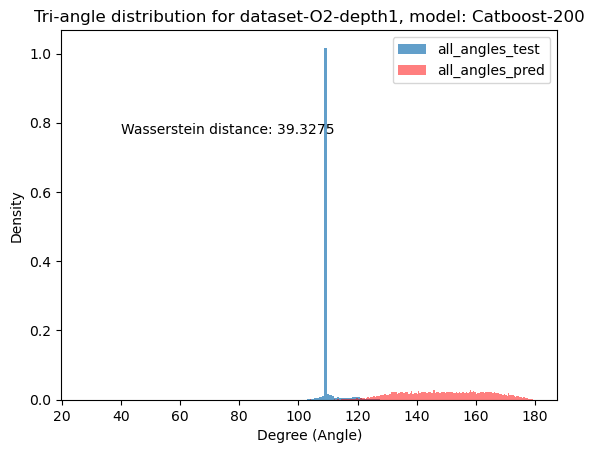

In [192]:
# Plot histograms
plt.hist(all_angles_test, bins=180, density=True, alpha=0.7, label='all_angles_test')
plt.hist(all_angles_pred, bins=180, density=True, alpha=0.5, color="red", label='all_angles_pred')
plt.title("Tri-angle distribution for dataset-O2-depth1, model: Catboost-200")
plt.xlabel("Degree (Angle)")
plt.ylabel("Density")

# Add Wasserstein distance text
plt.text(0.55, 0.75, f'Wasserstein distance: {distance:.4f}', 
         horizontalalignment='right', 
         verticalalignment='top', 
         transform=plt.gca().transAxes)

# Add legend
plt.legend()

# Save plot
plt.savefig("../img/testing/dataset-O2-depth1/tri-angle-distribution.png", bbox_inches='tight')
plt.show()

#### Bindungslängenverteilungen

In [193]:
all_bindinglengths_test = bindungslängen(y_test)

In [194]:
all_bindinglengths_pred = bindungslängen(y_pred)

In [195]:
# Calculate Wasserstein distance
distance = calculate_wasserstein_distance(all_bindinglengths_test, all_bindinglengths_pred, bins=100, range=(0, 1.5))
print(f'Wasserstein distance: {distance}')

Wasserstein distance: 0.5529021812483677


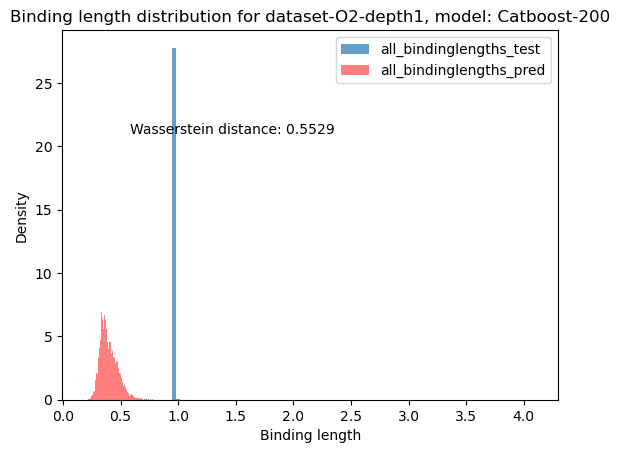

In [196]:
# Plot histograms
plt.hist(all_bindinglengths_test, bins=100, density=True, alpha=0.7, label='all_bindinglengths_test')
plt.hist(all_bindinglengths_pred, bins=100, density=True, alpha=0.5, color="red", label='all_bindinglengths_pred')
plt.title("Binding length distribution for dataset-O2-depth1, model: Catboost-200")
plt.xlabel("Binding length")
plt.ylabel("Density")

# Add Wasserstein distance text
plt.text(0.55, 0.75, f'Wasserstein distance: {distance:.4f}', 
         horizontalalignment='right', 
         verticalalignment='top', 
         transform=plt.gca().transAxes)

# Add legend
plt.legend()

# Save plot
plt.savefig("../img/testing/dataset-O2-depth1/bindinglength-distribution.png", bbox_inches='tight')
plt.show()

### 2. Gradient boosting n=500

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the base model
base_gb_model = GradientBoostingRegressor(n_estimators=500, random_state=42)

# Wrap the base model with MultiOutputRegressor
multi_gb_model = MultiOutputRegressor(base_gb_model)

# Train the model
multi_gb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = multi_gb_model.predict(X_test)

In [40]:
metrics = eval_regression(y_test, y_pred, X_test_coords)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.2574614818384948
R2 Bestimmtheitsmaß:  0.13588820128790827
Average Cosine Similarity:  0.386989373857404
Average Angle (degrees):  65.48343087294332
Durschnittliche Bindungslänge Differenz:  0.5644291735274944
Die Wasserstein Distanz zwischen den beiden Winkelverteilungen beträgt:  41.76332529707496


In [41]:
all_results["dataset-O2-depth1"].append(("gradientboosting", metrics))

### 3. Simple MLP

In [42]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model(f'model_checkpoints/best_model_simple_MLP_20240709-025014.h5')

In [43]:
# Apply the model to the test set
y_pred = model.predict(X_test)

274/274 [==============================] - 0s 674us/step


In [44]:
metrics = eval_regression(y_test, y_pred, X_test_coords)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.25740414553752267
R2 Bestimmtheitsmaß:  0.13633491795071753
Average Cosine Similarity:  0.3848137568555759
Average Angle (degrees):  65.92135157678246
Durschnittliche Bindungslänge Differenz:  0.5812526290364728
Die Wasserstein Distanz zwischen den beiden Winkelverteilungen beträgt:  46.30752765082267


In [45]:
all_results["dataset-O2-depth1"].append(("simple-MLP", metrics))

## Dataset-C4-Depth2

In [209]:
train_data = np.load('../data/dataset-C4-depth2/training-validation.npz')

X_train, y_train = train_data['X_train'], train_data['y_train']

# Split the data to training - validation (not testing yet!)
X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)

test_data = np.load('../data/dataset-C4-depth2/testing.npz')

X_test, y_test = test_data['X_test'], test_data['y_test']

print(X_test.shape, y_test.shape)

(43486, 132) (43486, 3)
(13590, 132) (13590, 3)


In [210]:
X_test_coords = extract_relative_coordinates(X_test)
X_test_coords_new = []
for c in X_test_coords:
    X_test_coords_new.append([c[0], c[1], c[2]])
X_test_coords = X_test_coords_new
X_test_coords = np.asarray(X_test_coords)

### 1. Catboost n=500

In [211]:
from catboost import CatBoostRegressor

# Initialize the base model
base_cat_model = CatBoostRegressor(iterations=500, random_state=42, verbose=0)

# Wrap the base model with MultiOutputRegressor
multi_cat_model = MultiOutputRegressor(base_cat_model)

# Train the model
multi_cat_model.fit(X_train, y_train)

# Predict on the test set
y_pred = multi_cat_model.predict(X_test)

In [63]:
metrics = eval_regression(y_test, y_pred, X_test_coords)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.010245934161739051
R2 Bestimmtheitsmaß:  0.9746528956194288
Average Cosine Similarity:  0.9893640176600442
Average Angle (degrees):  4.935628844738778
Durschnittliche Bindungslänge Differenz:  0.02219467249730922
Die Wasserstein Distanz zwischen den beiden Winkelverteilungen beträgt:  1.1743220505273484


In [64]:
all_results["dataset-C4-depth2"].append(("catboost-500", metrics))

#### Winkelverteilungen

In [212]:
all_angles_test = all_angles_H_central_neighbor(X_test_coords, y_test)

In [213]:
all_angles_pred = all_angles_H_central_neighbor(X_test_coords, y_pred)

In [214]:
# Calculate Wasserstein distance
distance = calculate_wasserstein_distance(all_angles_test, all_angles_pred, bins=180, range=(0, 180))
print(f'Wasserstein distance: {distance}')

Wasserstein distance: 1.1639195486877592


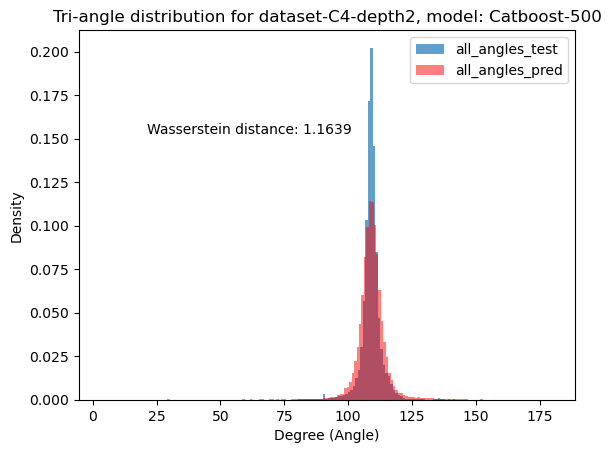

In [215]:
# Plot histograms
plt.hist(all_angles_test, bins=180, density=True, alpha=0.7, label='all_angles_test')
plt.hist(all_angles_pred, bins=180, density=True, alpha=0.5, color="red", label='all_angles_pred')
plt.title("Tri-angle distribution for dataset-C4-depth2, model: Catboost-500")
plt.xlabel("Degree (Angle)")
plt.ylabel("Density")

# Add Wasserstein distance text
plt.text(0.55, 0.75, f'Wasserstein distance: {distance:.4f}', 
         horizontalalignment='right', 
         verticalalignment='top', 
         transform=plt.gca().transAxes)

# Add legend
plt.legend()

# Save plot
plt.savefig("../img/testing/dataset-C4-depth2/tri-angle-distribution.png", bbox_inches='tight')
plt.show()

#### Bindungslängenverteilungen

In [216]:
all_bindinglengths_test = bindungslängen(y_test)

In [217]:
all_bindinglengths_pred = bindungslängen(y_pred)

In [218]:
# Calculate Wasserstein distance
distance = calculate_wasserstein_distance(all_bindinglengths_test, all_bindinglengths_pred, bins=100, range=(0, 1.5))
print(f'Wasserstein distance: {distance}')

Wasserstein distance: 0.060999206963900245


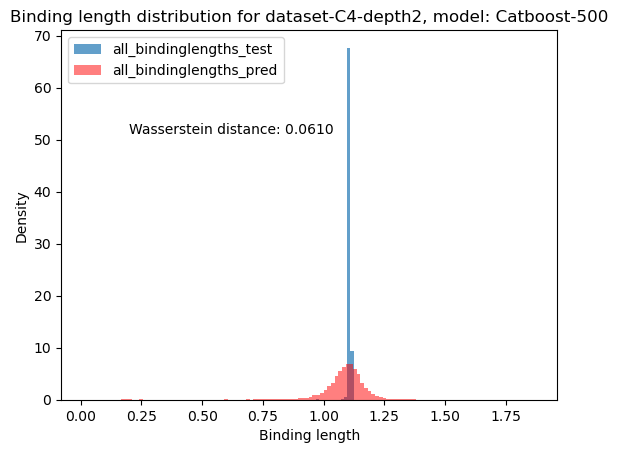

In [219]:
# Plot histograms
plt.hist(all_bindinglengths_test, bins=100, density=True, alpha=0.7, label='all_bindinglengths_test')
plt.hist(all_bindinglengths_pred, bins=100, density=True, alpha=0.5, color="red", label='all_bindinglengths_pred')
plt.title("Binding length distribution for dataset-C4-depth2, model: Catboost-500")
plt.xlabel("Binding length")
plt.ylabel("Density")

# Add Wasserstein distance text
plt.text(0.55, 0.75, f'Wasserstein distance: {distance:.4f}', 
         horizontalalignment='right', 
         verticalalignment='top', 
         transform=plt.gca().transAxes)

# Add legend
plt.legend()

# Save plot
plt.savefig("../img/testing/dataset-C4-depth2/bindinglength-distribution.png", bbox_inches='tight')
plt.show()

### 2. Random Forest n=500

In [65]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

In [ ]:
# Predict on the test set
y_pred = rf_model.predict(X_test)

In [66]:
metrics = eval_regression(y_test, y_pred, X_test_coords)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.009123694642988773
R2 Bestimmtheitsmaß:  0.9774380530790197
Average Cosine Similarity:  0.9880654893303901
Average Angle (degrees):  4.2809571743929355
Durschnittliche Bindungslänge Differenz:  0.0614930930914257
Die Wasserstein Distanz zwischen den beiden Winkelverteilungen beträgt:  0.36412285994603827


In [67]:
all_results["dataset-C4-depth2"].append(("randomforest-500", metrics))

### 3. Simple MLP

In [87]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model(f'model_checkpoints/best_model_simple_MLP_20240709-031301.h5')

In [ ]:
# Apply the model to the test set
y_pred = model.predict(X_test)

In [70]:
metrics = eval_regression(y_test, y_pred, X_test_coords)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.008301337188100307
R2 Bestimmtheitsmaß:  0.9794584945369867
Average Cosine Similarity:  0.9890621780721118
Average Angle (degrees):  5.251114348785872
Durschnittliche Bindungslänge Differenz:  0.026187446182319496
Die Wasserstein Distanz zwischen den beiden Winkelverteilungen beträgt:  1.290046112337503


In [71]:
all_results["dataset-C4-depth2"].append(("simple-MLP", metrics))

## Dataset-O2-Depth2

In [258]:
train_data = np.load('../data/dataset-O2-depth2/training-validation.npz')

X_train, y_train = train_data['X_train'], train_data['y_train']

# Split the data to training - validation (not testing yet!)
X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)

test_data = np.load('../data/dataset-O2-depth2/testing.npz')

X_test, y_test = test_data['X_test'], test_data['y_test']

print(X_test.shape, y_test.shape)

(27958, 44) (27958, 3)
(8738, 44) (8738, 3)


In [259]:
X_test_coords = extract_relative_coordinates(X_test)
X_test_coords_new = []
for c in X_test_coords:
    X_test_coords_new.append([c[0]])
X_test_coords = X_test_coords_new
X_test_coords = np.asarray(X_test_coords)

### 1. Simple MLP

In [222]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model(f'model_checkpoints/best_model_simple_MLP_20240709-032158.h5')

In [223]:
# Apply the model to the test set
y_pred = model.predict(X_test)

274/274 [==============================] - 0s 659us/step


In [224]:
metrics = eval_regression(y_test, y_pred, X_test_coords)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.10151758501759751
R2 Bestimmtheitsmaß:  0.6597180794283649
Average Cosine Similarity:  0.8036427100022888
Average Angle (degrees):  24.192115472648204
Durschnittliche Bindungslänge Differenz:  0.17458394459052462
Die Wasserstein Distanz zwischen den beiden Winkelverteilungen beträgt:  7.743010643167772


In [94]:
all_results["dataset-O2-depth2"].append(("simple-MLP", metrics))

#### Tri Winkelverteilungen

In [225]:
all_angles_test = all_angles_H_central_neighbor(X_test_coords, y_test)

In [226]:
all_angles_pred = all_angles_H_central_neighbor(X_test_coords, y_pred)

In [227]:
# Calculate Wasserstein distance
distance = calculate_wasserstein_distance(all_angles_test, all_angles_pred, bins=180, range=(0, 180))
print(f'Wasserstein distance: {distance}')

Wasserstein distance: 7.750743877317455


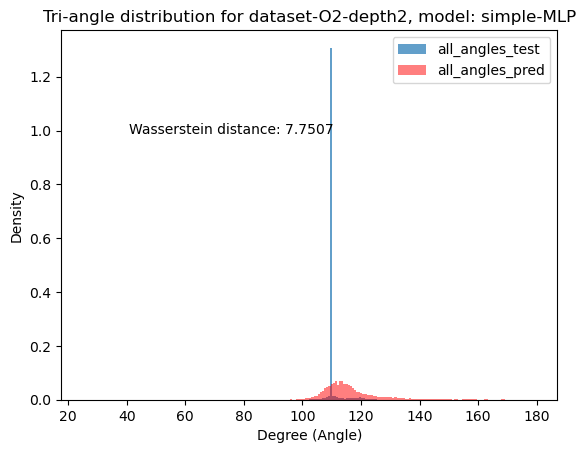

In [228]:
# Plot histograms
plt.hist(all_angles_test, bins=180, density=True, alpha=0.7, label='all_angles_test')
plt.hist(all_angles_pred, bins=180, density=True, alpha=0.5, color="red", label='all_angles_pred')
plt.title("Tri-angle distribution for dataset-O2-depth2, model: simple-MLP")
plt.xlabel("Degree (Angle)")
plt.ylabel("Density")

# Add Wasserstein distance text
plt.text(0.55, 0.75, f'Wasserstein distance: {distance:.4f}', 
         horizontalalignment='right', 
         verticalalignment='top', 
         transform=plt.gca().transAxes)

# Add legend
plt.legend()

# Save plot
plt.savefig("../img/testing/dataset-O2-depth2/tri-angle-distribution.png", bbox_inches='tight')
plt.show()

#### Bindungslängenverteilungen

In [229]:
all_bindinglengths_test = bindungslängen(y_test)

In [230]:
all_bindinglengths_pred = bindungslängen(y_pred)

In [256]:
# Calculate Wasserstein distance
distance = calculate_wasserstein_distance(all_bindinglengths_test, all_bindinglengths_pred, bins=20, range=(0, 5))
print(f'Wasserstein distance: {distance}')

Wasserstein distance: 0.10892080567635615


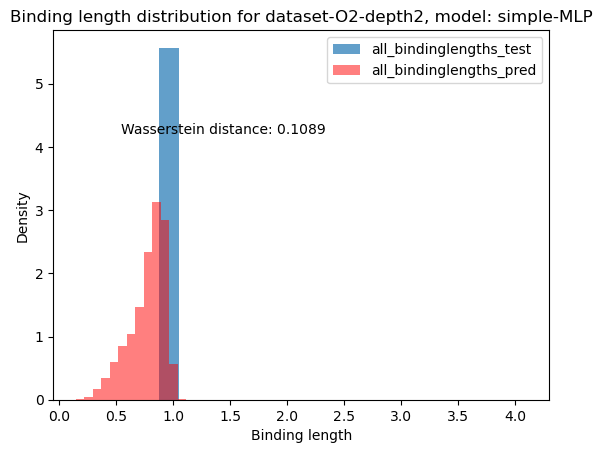

In [257]:
# Plot histograms
plt.hist(all_bindinglengths_test, bins=20, density=True, alpha=0.7, label='all_bindinglengths_test')
plt.hist(all_bindinglengths_pred, bins=20, density=True, alpha=0.5, color="red", label='all_bindinglengths_pred')
plt.title("Binding length distribution for dataset-O2-depth2, model: simple-MLP")
plt.xlabel("Binding length")
plt.ylabel("Density")

# Add Wasserstein distance text
plt.text(0.55, 0.75, f'Wasserstein distance: {distance:.4f}', 
         horizontalalignment='right', 
         verticalalignment='top', 
         transform=plt.gca().transAxes)

# Add legend
plt.legend()

# Save plot
plt.savefig("../img/testing/dataset-O2-depth2/bindinglength-distribution.png", bbox_inches='tight')
plt.show()

#### Dihedralwinkelverteilung

In [171]:
X_test_coords = extract_relative_coordinates(X_test)

In [176]:
all_dihedral_angles_test = []
for x_rel, y in zip(X_test_coords, y_test):
    for i, x_rel2 in enumerate(x_rel[1:]):
        dihedral_angle = compute_dihedral([0,0,0], x_rel[0], y, x_rel2)
        all_dihedral_angles_test.append(dihedral_angle)

In [177]:
all_dihedral_angles_pred = []
for x_rel, y in zip(X_test_coords, y_pred):
    for i, x_rel2 in enumerate(x_rel[1:]):
        dihedral_angle = compute_dihedral([0,0,0], x_rel[0], y, x_rel2)
        all_dihedral_angles_pred.append(dihedral_angle)

In [181]:
# Calculate Wasserstein distance
distance = calculate_wasserstein_distance(all_dihedral_angles_test, all_dihedral_angles_pred, bins=180, range=(0, 180))
print(f'Wasserstein distance: {distance}')

Wasserstein distance: 21.931127407669194


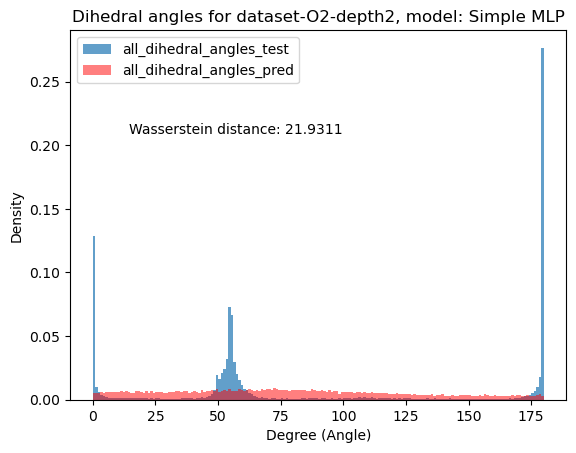

In [183]:
# Plot histograms
plt.hist(all_dihedral_angles_test, bins=180, density=True, alpha=0.7, label='all_dihedral_angles_test')
plt.hist(all_dihedral_angles_pred, bins=180, density=True, alpha=0.5, color="red", label='all_dihedral_angles_pred')
plt.title("Dihedral angles for dataset-O2-depth2, model: Simple MLP")
plt.xlabel("Degree (Angle)")
plt.ylabel("Density")

# Add Wasserstein distance text
plt.text(0.55, 0.75, f'Wasserstein distance: {distance:.4f}', 
         horizontalalignment='right', 
         verticalalignment='top', 
         transform=plt.gca().transAxes)

# Add legend
plt.legend()

# Save plot
plt.savefig("../img/testing/dataset-O2-depth2/dihedral-distribution.png", bbox_inches='tight')
plt.show()

### 2. Catboost n=500 

In [95]:
from catboost import CatBoostRegressor

# Initialize the base model
base_cat_model = CatBoostRegressor(iterations=500, random_state=42, verbose=0)

# Wrap the base model with MultiOutputRegressor
multi_cat_model = MultiOutputRegressor(base_cat_model)

# Train the model
multi_cat_model.fit(X_train, y_train)

# Predict on the test set
y_pred = multi_cat_model.predict(X_test)

In [96]:
metrics = eval_regression(y_test, y_pred, X_test_coords)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.10124415934339968
R2 Bestimmtheitsmaß:  0.6606082356226189
Average Cosine Similarity:  0.8011655985351339
Average Angle (degrees):  24.96661890592813
Durschnittliche Bindungslänge Differenz:  0.200736546432575
Die Wasserstein Distanz zwischen den beiden Winkelverteilungen beträgt:  8.816364271000229


In [97]:
all_results["dataset-O2-depth2"].append(("catboost-500", metrics))

### 3. SVR

In [260]:
from sklearn.svm import SVR

# Initialize the base model
base_svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Wrap the base model with MultiOutputRegressor
multi_svr_model = MultiOutputRegressor(base_svr_model)

# Train the model
multi_svr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = multi_svr_model.predict(X_test)

In [261]:
metrics = eval_regression(y_test, y_pred, X_test_coords)

Alle folgenden Metriken sind H zu H'
Mittlerer Abstand:  0.10525411673286111
R2 Bestimmtheitsmaß:  0.6475924871776879
Average Cosine Similarity:  0.8000181963836118
Average Angle (degrees):  22.237632867933165
Durschnittliche Bindungslänge Differenz:  0.12351331475644622
Die Wasserstein Distanz zwischen den beiden Winkelverteilungen beträgt:  4.583783474479286


In [263]:
all_results["dataset-O2-depth2"].append(("SVR", metrics))

# Output Latex code for table

In [265]:
# Function to create LaTeX tables for each dataset
def create_latex_table(dataset_name, results):
    df = pd.DataFrame(results, columns=['Model', 'Metrics'])
    metrics_df = pd.DataFrame(df['Metrics'].tolist(), index=df['Model'], columns=['MSE', 'R2', 'Avg Angle', 'Avg Bindungslänge Diff', 'Wasserstein'])
    latex_code = metrics_df.to_latex(index=True, caption=dataset_name, label=f"tab:{dataset_name.replace('-', '_')}", float_format="%.4f")
    return latex_code

# Generate LaTeX code for each dataset
latex_tables = {}
for dataset, results in all_results.items():
    latex_tables[dataset] = create_latex_table(dataset, results)

# Print LaTeX code for each dataset table
for dataset, latex_code in latex_tables.items():
    print(f"% LaTeX table for {dataset}")
    print(latex_code)
    print("\n")

% LaTeX table for dataset-C4-depth1
\begin{table}
\caption{dataset-C4-depth1}
\label{tab:dataset_C4_depth1}
\begin{tabular}{lrrrrr}
\toprule
 & MSE & R2 & Avg Angle & Avg Bindungslänge Diff & Wasserstein \\
Model &  &  &  &  &  \\
\midrule
SVR & 0.0086 & 0.9789 & 3.4968 & 0.0239 & 0.3470 \\
simple-MLP & 0.0076 & 0.9812 & 4.8606 & 0.0117 & 1.0926 \\
catboost & 0.0097 & 0.9759 & 4.6228 & 0.0196 & 0.9517 \\
\bottomrule
\end{tabular}
\end{table}



% LaTeX table for dataset-C4-depth2
\begin{table}
\caption{dataset-C4-depth2}
\label{tab:dataset_C4_depth2}
\begin{tabular}{lrrrrr}
\toprule
 & MSE & R2 & Avg Angle & Avg Bindungslänge Diff & Wasserstein \\
Model &  &  &  &  &  \\
\midrule
catboost-500 & 0.0102 & 0.9747 & 4.9356 & 0.0222 & 1.1743 \\
randomforest-500 & 0.0091 & 0.9774 & 4.2810 & 0.0615 & 0.3641 \\
simple-MLP & 0.0083 & 0.9795 & 5.2511 & 0.0262 & 1.2900 \\
\bottomrule
\end{tabular}
\end{table}



% LaTeX table for dataset-O2-depth1
\begin{table}
\caption{dataset-O2-depth1}
\label{

In [264]:
import pickle

# Export the dictionary with pickle
with open('all_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)